In [1]:
pip install lifetimes

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import lifetimes as CLV
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

from lifetimes import BetaGeoFitter, GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Dataisgood-com/CLV_analysis/main/online_retail.csv')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
df.shape

(541909, 8)

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
df['InvoiceNo'].duplicated().isnull().sum()

0

This manipulation involves imputing random values to missing customer IDs.

In [11]:
missing_indices = df['CustomerID'].isna()
random_values = np.random.randint(low=18287, high=135080+18287)
df.loc[missing_indices, 'CustomerID'] = random_values

In [12]:
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [13]:
df.duplicated().sum()

5268

In [14]:
df = df.drop_duplicates()

In [15]:
df.shape

(536641, 8)

This data manipulation involves filtering out rows where 'Quantity' is less than or equal to 0, 'UnitPrice' is less than or equal to 0, and removing rows with 'InvoiceNo' containing "C" (indicating returns). This is done to clean the data by excluding invalid or unwanted records, ensuring that the analysis is based on valid and meaningful transactions.

In [16]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [17]:
cat_columns = df.select_dtypes(include = ['object']).columns

In [18]:
for col in cat_columns:
    print(df[col].value_counts())

573585    1114
581219     749
581492     731
580729     721
558475     705
          ... 
539048       1
539051       1
539052       1
569818       1
543348       1
Name: InvoiceNo, Length: 19960, dtype: int64
85123A    2253
85099B    2109
22423     2007
47566     1699
20725     1582
          ... 
23605        1
90081B       1
84661a       1
90035C       1
23843        1
Name: StockCode, Length: 3922, dtype: int64
WHITE HANGING HEART T-LIGHT HOLDER    2311
JUMBO BAG RED RETROSPOT               2109
REGENCY CAKESTAND 3 TIER              2007
PARTY BUNTING                         1699
LUNCH BAG RED RETROSPOT               1581
                                      ... 
GLASS BEAD HOOP NECKLACE BLACK           1
HOT WATER BOTTLE BABUSHKA LARGE          1
BIRTHDAY BANNER TAPE                     1
GARLAND, MAGIC GARDEN 1.8M               1
PAPER CRAFT , LITTLE BIRDIE              1
Name: Description, Length: 4026, dtype: int64
2011-10-31 14:41:00    1114
2011-12-08 09:28:00     749
2011-1

In [19]:
df = df[~df['InvoiceNo'].str.contains('C')]

We will create a function called cap_outliers that caps outliers in a specified DataFrame column by setting values below the 5th percentile (q1) to the 5th percentile value and values above the 95th percentile (q2) to the 95th percentile value.

In [20]:
def cap_outliers(dataframe, variable, upper = 0.95, lower = 0.05):
    upper_bound = dataframe[variable].quantile(upper)
    lower_bound = dataframe[variable].quantile(lower)
    dataframe[variable] = np.clip(dataframe[variable], lower_bound, upper_bound)
    return dataframe

df = cap_outliers(df, 'UnitPrice')
df = cap_outliers(df, 'Quantity')
df.describe()

,Quantity,UnitPrice,CustomerID
count,524878.000000,524878.000000,524878.000000
mean,7.127433,3.053662,41410.634039
std,8.114955,2.609927,45049.341684
min,1.000000,0.420000,12346.000000
25%,1.000000,1.250000,14375.000000
50%,4.000000,2.080000,16265.000000
75%,11.000000,4.130000,119015.000000
max,30.000000,9.950000,119015.000000


<AxesSubplot:xlabel='Country', ylabel='Values'>

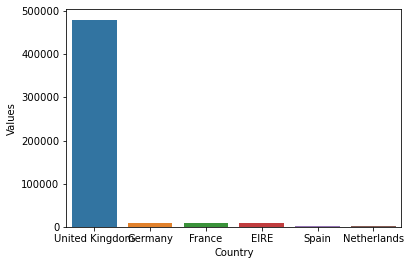

In [21]:
data_country = df['Country'].value_counts().reset_index()
data_country.columns = ['Country', 'Values']
sns.barplot(x = 'Country', y = 'Values', data = data_country[:6:])

United Kingdom has highest number of customers, followed by European countries, namely Germany, France, EIRE, Spain, and Netherlands.

In [22]:
df['InvoiceDate'].max()

'2011-12-09 12:50:00'

After we've completed the data preprocessing phase, the next crucial step is to construct an RFM (Recency, Frequency, Monetary) dataset. But what exactly do these terms mean?

Frequency: This metric represents the number of repeat purchases a customer has made. It's actually one less than the total number of purchases, but it's more accurately defined as the count of time periods in which a customer made a purchase. For example, if you're measuring in days, it's the count of days on which the customer made a purchase.

Recency: Recency measures the age of a customer when they made their most recent purchase. It's calculated as the duration between a customer's first purchase and their latest purchase. If a customer has only made a single purchase, their recency is 0.

T: T represents the age of the customer using the chosen time units (e.g., weekly in the dataset mentioned). It's calculated as the duration between a customer's first purchase and the end of the period you're studying.

Monetary Value: This metric signifies the average value of a customer's purchases. It's determined by dividing the sum of all a customer's purchases by the total number of purchases. It's important to note that the denominator in this calculation differs from the frequency calculation described earlier.

In essence, by constructing the RFM dataset, we're quantifying customer behavior in terms of how recently they made a purchase, how frequently they make purchases, the total duration of their engagement, and the average value of their purchases. This dataset serves as a valuable foundation for various customer segmentation and analysis techniques.

This code computes the RFM (Recency, Frequency, Monetary) summary statistics from a transaction dataset using the Lifetimes library for Customer Lifetime Value (CLV) analysis. The summary_data_from_transaction_data function computes the following RFM metrics for each customer. The resulting RFM dataset contains these calculated RFM metrics for each customer and serves as the basis for further analysis, such as predictive modeling of customer lifetime value and customer segmentation.

In [23]:
df['TotalPrice'] = df['UnitPrice']*df['Quantity']
RFM = CLV.utils.summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', 'TotalPrice', observation_period_end = '2011-12-10')

In [24]:
RFM

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,326.0,0.000000
12347.0,6.0,365.0,368.0,544.711667
12348.0,3.0,283.0,359.0,101.716667
12349.0,0.0,0.0,19.0,0.000000
12350.0,0.0,0.0,311.0,0.000000
...,...,...,...,...
18281.0,0.0,0.0,181.0,0.000000
18282.0,1.0,119.0,127.0,72.240000
18283.0,13.0,334.0,338.0,148.863077


In [25]:
#customers who shopped more than twice
RFM = RFM[RFM['frequency'] > 2]
RFM

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,365.0,368.0,544.711667
12348.0,3.0,283.0,359.0,101.716667
12352.0,6.0,260.0,297.0,197.190000
12359.0,3.0,274.0,332.0,1521.016667
12362.0,9.0,292.0,296.0,500.257778
...,...,...,...,...
18257.0,6.0,257.0,297.0,325.468333
18260.0,5.0,186.0,359.0,460.106000
18272.0,5.0,244.0,247.0,481.896000


Frequency/Recency Analysis using the BG/NBD Model:

It is a technique employed to gain insights into customer behavior, specifically regarding how often customers make purchases and how recently they've made their last purchase. It involves the use of the Lifetimes library and the Bayesian-Gamma Negative Binomial Distribution (BG/NBD) model.

People are different! Some customers might buy frequently, while others might buy rarely. The BG/NBD model accounts for this by using a Gamma distribution to represent the heterogeneity in customer "excitement" for buying. A high gamma value indicates a more "excited" customer who buys frequently, while a low value suggests a less frequent buyer.

Just like you wouldn't grab a handful of candy every single day, customers might not buy every time they visit the store. The BG/NBD model uses a negative binomial distribution to capture this "purchase occasion" process. This distribution considers the number of times a customer has the opportunity to buy (think visits to the store) and the probability of them actually making a purchase during each visit.

The "Bayesian" part of the model refers to how it incorporates prior information (if available) about customer behavior. 

α (alpha): This parameter controls the "shape" of the gamma distribution, reflecting customer heterogeneity in purchase frequency.
β (beta): This parameter controls the "scale" of the gamma distribution, influencing the overall level of purchase frequency.
r (r): This parameter controls the "shape" of the negative binomial distribution, reflecting the clumping of purchase occasions.
p (p): This parameter controls the "probability of purchase" within each occasion, influencing how often a customer buys something during a visit.

In [26]:
bgf = BetaGeoFitter(penalizer_coef =0.0)
bgf.fit(RFM['frequency'], RFM['recency'], RFM['T'])

<lifetimes.BetaGeoFitter: fitted with 1416 subjects, a: 0.02, alpha: 98.38, b: 22.38, r: 2.53>

In [27]:
predicted_purchases = bgf.predict(12, RFM['frequency'], RFM['recency'], RFM['T'])

In [28]:
RFM['predicted_purchases'] = predicted_purchases

In [29]:
RFM

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12347.0,6.0,365.0,368.0,544.711667,0.219190
12348.0,3.0,283.0,359.0,101.716667,0.144648
12352.0,6.0,260.0,297.0,197.190000,0.258304
12359.0,3.0,274.0,332.0,1521.016667,0.153787
12362.0,9.0,292.0,296.0,500.257778,0.350407
...,...,...,...,...,...
18257.0,6.0,257.0,297.0,325.468333,0.258270
18260.0,5.0,186.0,359.0,460.106000,0.192088
18272.0,5.0,244.0,247.0,481.896000,0.261251


The Gamma-Gamma model is used to predict the monetary value for each transaction.

In [30]:
ggf = GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(RFM['frequency'], RFM['monetary_value'])

predicted_monetary_value = ggf.conditional_expected_average_profit(RFM['frequency'], RFM['monetary_value'])



In [31]:
predicted_monetary_value = ggf.conditional_expected_average_profit(RFM['frequency'], RFM['monetary_value'])

In [32]:
RFM['predicted_monetary_value'] = predicted_monetary_value

In [33]:
RFM

,frequency,recency,T,monetary_value,predicted_purchases,predicted_monetary_value
CustomerID,,,,,,
12347.0,6.0,365.0,368.0,544.711667,0.219190,481.072885
12348.0,3.0,283.0,359.0,101.716667,0.144648,243.905168
12352.0,6.0,260.0,297.0,197.190000,0.258304,259.452142
12359.0,3.0,274.0,332.0,1521.016667,0.153787,908.314359
12362.0,9.0,292.0,296.0,500.257778,0.350407,464.216069
...,...,...,...,...,...,...
18257.0,6.0,257.0,297.0,325.468333,0.258270,341.257515
18260.0,5.0,186.0,359.0,460.106000,0.192088,423.195240
18272.0,5.0,244.0,247.0,481.896000,0.261251,436.152288


In [34]:
RFM['predicted_CLV'] = RFM['predicted_purchases'] * RFM['predicted_monetary_value']

In [35]:
RFM.reset_index()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,predicted_monetary_value,predicted_CLV
0,12347.0,6.0,365.0,368.0,544.711667,0.219190,481.072885,105.446498
1,12348.0,3.0,283.0,359.0,101.716667,0.144648,243.905168,35.280429
2,12352.0,6.0,260.0,297.0,197.190000,0.258304,259.452142,67.017399
3,12359.0,3.0,274.0,332.0,1521.016667,0.153787,908.314359,139.687267
4,12362.0,9.0,292.0,296.0,500.257778,0.350407,464.216069,162.664695
...,...,...,...,...,...,...,...,...
1411,18257.0,6.0,257.0,297.0,325.468333,0.258270,341.257515,88.136651
1412,18260.0,5.0,186.0,359.0,460.106000,0.192088,423.195240,81.290678
1413,18272.0,5.0,244.0,247.0,481.896000,0.261251,436.152288,113.945390
1414,18283.0,13.0,334.0,338.0,148.863077,0.426608,194.602722,83.018987


In [36]:
RFM.describe()

,frequency,recency,T,monetary_value,predicted_purchases,predicted_monetary_value,predicted_CLV
count,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000
mean,7.641949,266.344633,300.036723,365.671310,0.305705,371.624301,137.349592
std,11.199743,86.242520,79.620771,304.850877,0.286799,221.039211,842.079659
min,3.000000,20.000000,30.000000,6.783333,0.051306,61.280873,8.745011
25%,3.000000,214.000000,262.000000,195.520181,0.189822,267.980320,59.564638
50%,5.000000,281.000000,323.500000,297.277083,0.241540,325.238056,81.798981
75%,8.000000,343.000000,366.000000,437.921250,0.346218,407.816589,120.064941
max,272.000000,373.000000,374.000000,4524.377574,6.971293,4472.949825,31182.243077


In [37]:
RFM.loc[RFM['predicted_CLV'] > 1000]

,frequency,recency,T,monetary_value,predicted_purchases,predicted_monetary_value,predicted_CLV
CustomerID,,,,,,,
12415.0,15.0,313.0,338.0,2618.857333,0.481123,2202.280302,1059.568385
13089.0,65.0,367.0,370.0,770.417077,1.729047,750.418451,1297.508898
14096.0,16.0,97.0,102.0,3061.071250,1.108152,2588.295714,2868.224625
14156.0,42.0,362.0,372.0,1267.981667,1.134754,1200.504261,1362.277453
14298.0,24.0,352.0,361.0,1614.361250,0.692284,1459.493391,1010.384490
14646.0,44.0,353.0,355.0,2210.416364,1.230737,2078.027005,2557.505300
14911.0,131.0,372.0,374.0,910.363969,3.390424,896.636471,3039.977864
17511.0,27.0,371.0,374.0,1604.634815,0.749560,1466.135925,1098.956795
17841.0,111.0,372.0,374.0,347.177928,2.882570,347.829584,1002.643104


In [38]:
RFM.loc[RFM['predicted_CLV'] > 4000]

,frequency,recency,T,monetary_value,predicted_purchases,predicted_monetary_value,predicted_CLV
CustomerID,,,,,,,
119015.0,272.0,373.0,374.0,4524.377574,6.971293,4472.949825,31182.243077


The 24279.0 customer ID of predicted_CLV is an outlier.

In [39]:
RFM.drop(RFM.loc[RFM['predicted_CLV'] > 4000].index, axis = 0, inplace = True)

In [40]:
RFM.describe()

,frequency,recency,T,monetary_value,predicted_purchases,predicted_monetary_value,predicted_CLV
count,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000
mean,7.455124,266.269258,299.984452,362.732295,0.300994,368.725838,115.409738
std,8.721484,86.226341,79.624613,284.183028,0.225540,192.324025,165.878899
min,3.000000,20.000000,30.000000,6.783333,0.051306,61.280873,8.745011
25%,3.000000,214.000000,262.000000,195.497204,0.189780,267.961101,59.542677
50%,5.000000,281.000000,323.000000,297.266667,0.241445,325.165978,81.785607
75%,8.000000,343.000000,366.000000,437.573750,0.345887,407.287165,120.021950
max,131.000000,373.000000,374.000000,3233.737273,3.390424,2588.295714,3039.977864


<AxesSubplot:xlabel='CustomerID', ylabel='predicted_CLV'>

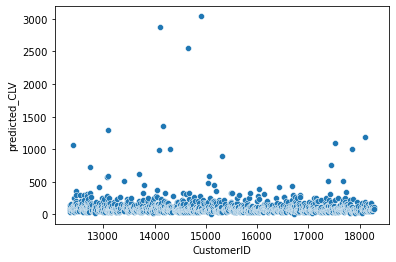

In [41]:
sns.scatterplot(x = 'CustomerID', y = 'predicted_CLV', data = RFM)

In [42]:
RFM = ((RFM - RFM.min()) / (RFM.max() - RFM.min())) * 9 + 1
max_iterations = 100
old_centroids = pd.DataFrame()
iteration = 1

Segmenting customers into different groups based on their CLV can be done using various methods, such as quantiles or clustering algorithms. This code uses k means algorithm to segment the consumers.

In [43]:
from sklearn.cluster import KMeans

In [123]:
features = ['predicted_purchases', 'predicted_monetary_value', 'predicted_CLV']

In [124]:
kmeans = KMeans(5)

In [125]:
kmeans.fit(RFM)

KMeans(n_clusters=5)

In [126]:
RFM

,frequency,recency,T,monetary_value,predicted_purchases,predicted_monetary_value,predicted_CLV
CustomerID,,,,,,,
12347.0,1.210938,9.796034,9.843023,2.500286,1.452503,2.495095,1.287115
12348.0,1.000000,7.705382,9.607558,1.264770,1.251588,1.650419,1.078786
12352.0,1.210938,7.118980,7.985465,1.531046,1.557926,1.705790,1.173016
12359.0,1.000000,7.475921,8.901163,5.223209,1.276221,4.016722,1.388779
12362.0,1.421875,7.934844,7.959302,2.376304,1.806175,2.435060,1.457001
...,...,...,...,...,...,...,...
18245.0,1.070312,9.362606,9.529070,2.498811,1.325818,2.432892,1.211051
18257.0,1.210938,7.042493,7.985465,1.888815,1.557836,1.997141,1.235721
18260.0,1.140625,5.232295,9.607558,2.264320,1.379453,2.288963,1.215395


In [127]:
from sklearn.decomposition import PCA
from IPython.display import clear_output

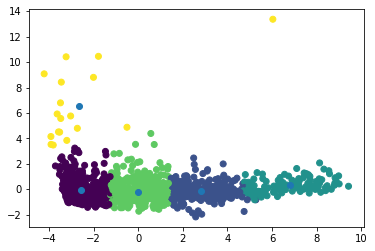

In [128]:
labels = kmeans.labels_
centroids = pd.DataFrame(kmeans.cluster_centers_)

pca = PCA(n_components = 2)
data_2d = pca.fit_transform(RFM)
centroids_2d = pca.transform(centroids)
clear_output(wait=True)
plt.scatter(x = data_2d[:,0], y = data_2d[:,1], c = labels)
plt.scatter(x = centroids_2d[:,0], y = centroids_2d[:,1])
plt.show()

In [129]:
explained_variance = pca.explained_variance_ratio_

In [130]:
print("Explained Variance Ratio:")
for i, ratio in enumerate(explained_variance):
    print(f"  PC{i+1}: {ratio:.4f}")

Explained Variance Ratio:
  PC1: 0.7660
  PC2: 0.1104


In [131]:
loadings = pca.components_.T

In [132]:
print("\nLoadings (Top 3 for each PC):")
for i in range(2):
    print(f"  PC{i+1}:")
    for feature, value in sorted(zip(features, map(abs, loadings[i])), key=lambda x: x[1], reverse=True)[:3]:
            print(f"    - {feature}: {value:.4f}")


Loadings (Top 3 for each PC):
  PC1:
    - predicted_monetary_value: 0.2227
    - predicted_purchases: 0.0698
  PC2:
    - predicted_purchases: 0.7271
    - predicted_monetary_value: 0.0960
